In [44]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data cleaning

In [45]:
#Read in income data
avg_house_prices = pd.read_csv('https://query.data.world/s/4YkmYcRnpcRqTmJ9qWn5KRALu157jX')
avg_house_prices = avg_house_prices[avg_house_prices['CountyName'] == 'San Diego'] 

#Extract zipcode, city, 2015-01 column
avg_house_prices = avg_house_prices[['RegionName', 'City', '2015-01']]
avg_house_prices.dropna(inplace=True)


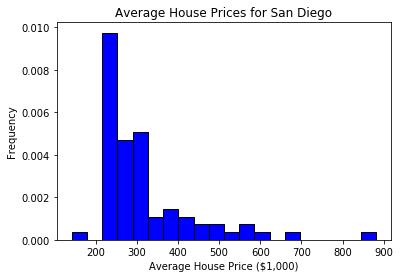

In [46]:
#Plot histogram of avg house prices
histogram = plt.hist(avg_house_prices['2015-01'], 20, edgecolor='black', facecolor='blue',normed=1)
plt.xlabel('Average House Price ($1,000)')
plt.ylabel('Frequency')
plt.title('Average House Prices for San Diego')

f1 = plt.gcf()

In [47]:
#Original df
df = pd.read_csv("resident_survey_weighted_datasd.csv")

#Create new df (data) that we will drop columns from
data = pd.read_csv("resident_survey_weighted_datasd.csv")

data.head()

,Num,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q2_1,Q2_2,Q2_3,...,Q25_1st,Q25_2nd,Q25_3rd,Q25_4th,Q25_5th,Q25_other,Q26,Q27,Q28,ZIP
0,1,5,4,4,3,3,3,4,5,3,...,3,NaN,NaN,NaN,NaN,NaN,2,2,7,92124
1,2,5,5,9,3,4,5,3,3,4,...,5,NaN,NaN,NaN,NaN,NaN,1,1,9,92115
2,3,4,3,4,4,4,5,4,4,4,...,1,NaN,NaN,NaN,NaN,NaN,1,1,9,92105
3,4,4,4,4,3,3,2,2,1,2,...,5,NaN,NaN,NaN,NaN,NaN,2,2,8,92102
4,5,5,5,5,4,5,5,5,5,4,...,3,NaN,NaN,NaN,NaN,NaN,2,2,4,92139


In [48]:
#Extract questions that ask residents to rate their satisfaction on a topic from 1-5
data.drop(data.columns[99:], axis=1, inplace=True)
data.drop(data.columns[0:7], axis=1, inplace=True)
#data.head(5)

data.drop(data.filter(like='Q4', axis=1), axis=1, inplace=True)
data.drop(data.filter(like='Q5', axis=1), axis=1, inplace=True)
data.drop(data.filter(like='Q10', axis=1), axis=1, inplace=True)
#data.head(5)

In [49]:
#Find total surveys submitted per zip code
total_zip = pd.DataFrame(df['ZIP'].value_counts())

#Only keep zipcodes who submitted more than 20 surveys
#total_zip = total_zip[total_zip['ZIP'] > 20]

#Convert total_zip to a dataframe, tell me if yall know a better way to do this
total_zip.index.name = 'x'
total_zip.reset_index(inplace=True)
total_zip.columns = ['ZIP', 'count']

#Add zipcode column back into data
data['ZIP'] = df['ZIP']

#Drop all rows whose zipcode has <20 surveys
data = data[data['ZIP'].isin(total_zip['ZIP'])].dropna()
data.head(10)

,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q3_1,Q3_2,Q3_3,...,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q15_2,Q15_3,Q15_4,ZIP
0,4,5,3,3,4,3,3,4,4,3,...,3,4,9,9,3,4,4,4,4,92124
1,3,3,4,4,5,5,5,3,4,5,...,3,4,3,2,3,5,4,5,4,92115
2,4,4,4,3,3,4,3,3,4,4,...,5,5,5,3,4,4,4,4,5,92105
3,2,1,2,4,4,4,2,4,3,3,...,2,4,4,2,3,3,4,3,3,92102
4,5,5,4,4,4,4,3,4,4,3,...,4,3,3,3,4,3,3,3,3,92139
5,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,92101
6,3,3,3,4,3,4,3,4,5,4,...,3,3,4,3,9,4,4,4,4,99999
7,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,92131
8,4,4,3,4,5,4,4,4,4,4,...,3,4,9,3,2,4,4,4,4,92117
9,4,3,2,4,3,3,1,3,4,3,...,3,3,1,3,2,2,3,2,1,92114


In [50]:
#Convert 9s (meaning "don't know") to NaNs
data.replace(9, np.nan, inplace=True)
data.head(10)

,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q3_1,Q3_2,Q3_3,...,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q15_2,Q15_3,Q15_4,ZIP
0,4.0,5.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,3.0,...,3.0,4.0,NaN,NaN,3.0,4.0,4.0,4.0,4.0,92124
1,3.0,3.0,4.0,4.0,5.0,5.0,5.0,3.0,4.0,5.0,...,3.0,4.0,3.0,2.0,3.0,5.0,4.0,5.0,4.0,92115
2,4.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,...,5.0,5.0,5.0,3.0,4.0,4.0,4.0,4.0,5.0,92105
3,2.0,1.0,2.0,4.0,4.0,4.0,2.0,4.0,3.0,3.0,...,2.0,4.0,4.0,2.0,3.0,3.0,4.0,3.0,3.0,92102
4,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,...,4.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,92139
5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,92101
6,3.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,5.0,4.0,...,3.0,3.0,4.0,3.0,NaN,4.0,4.0,4.0,4.0,99999
7,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,92131
8,4.0,4.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,...,3.0,4.0,NaN,3.0,2.0,4.0,4.0,4.0,4.0,92117
9,4.0,3.0,2.0,4.0,3.0,3.0,1.0,3.0,4.0,3.0,...,3.0,3.0,1.0,3.0,2.0,2.0,3.0,2.0,1.0,92114


In [51]:
#Get bottom 10 questions with lowest avg rating per zipcode
mean = data.mean()
bottom_10 = mean.nsmallest(n=11, keep='first')
print(bottom_10)

Q14_3     2.304450
Q3_8      2.402384
Q8_3      2.441585
Q14_14    2.564475
Q14_4     2.580215
Q8_10     2.584749
Q8_4      2.645358
Q14_5     2.652632
Q14_6     2.695233
Q14_2     2.703271
Q14_1     2.832529
dtype: float64


In [52]:
#Read in survey questions
questions = pd.read_csv("resident_survey_dictionary_datasd.csv")
#questions.head(5)


In [53]:
Q1 = (questions.loc[questions['question_number']=='Q14_3'])['question_text']
Q2 = (questions.loc[questions['question_number']=='Q3_8'])['question_text']
Q3 = (questions.loc[questions['question_number']=='Q8_3'])['question_text']
Q4 = (questions.loc[questions['question_number']=='Q14_14'])['question_text']
Q5 = (questions.loc[questions['question_number']=='Q14_4'])['question_text']
Q6 = (questions.loc[questions['question_number']=='Q8_10'])['question_text']
Q7 = (questions.loc[questions['question_number']=='Q8_4'])['question_text']
Q8 = (questions.loc[questions['question_number']=='Q14_5'])['question_text']
Q9 = (questions.loc[questions['question_number']=='Q14_6'])['question_text']
Q10 = (questions.loc[questions['question_number']=='Q14_2'])['question_text']

print(Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10)

95    Ease of obtaining permits from Development Ser...
Name: question_text, dtype: object 23    Maintenance of City streets, sidewalks, and in...
Name: question_text, dtype: object 54    Condition and maintenance of City streets
Name: question_text, dtype: object 106    Quality/variety of entertainment, expositions,...
Name: question_text, dtype: object 96    Efforts to address homelessness
Name: question_text, dtype: object 61    Quality of street repairs
Name: question_text, dtype: object 55    Condition and maintenance of streets in YOUR n...
Name: question_text, dtype: object 97    Efforts to assist low- to moderate-income resi...
Name: question_text, dtype: object 98    Efforts to plan for future growth
Name: question_text, dtype: object 94    Code enforcement
Name: question_text, dtype: object


In [54]:
#Extract street questions and zipcodes out of the top 10 
street_qs = data[['Q8_3', 'Q3_8', 'Q8_4', 'Q8_10', 'ZIP']]
#street_qs

In [55]:
#Find average rating on all questions for each zip code

avg_ratings_per_zip = street_qs.groupby('ZIP', as_index=False).mean()
#

#FOR GEOGRAPH: Extract 5 zipcodes with lowest average rating
lowest_q83 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_3',keep='first')[['ZIP','Q8_3']]
lowest_q38 = avg_ratings_per_zip.nsmallest(n=5, columns='Q3_8',keep='first')[['ZIP','Q3_8']]
lowest_q84 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_4',keep='first')[['ZIP','Q8_4']]
lowest_q810 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_10',keep='first')[['ZIP','Q8_10']]


#avg_ratings_per_zip.head()

In [57]:
#Add avg house prices 2015-01 data to ratings data
rating_and_price = avg_ratings_per_zip.merge(avg_house_prices, left_on='ZIP', right_on='RegionName')

#Compute correlation between avg rating and avg house price for each question
Q8_3_corr = rating_and_price['Q8_3'].corr(rating_and_price['2015-01'])
Q3_8_corr = rating_and_price['Q3_8'].corr(rating_and_price['2015-01'])
Q8_4_corr = rating_and_price['Q8_4'].corr(rating_and_price['2015-01'])
Q8_10_corr = rating_and_price['Q8_10'].corr(rating_and_price['2015-01'])

print(Q8_3_corr,Q3_8_corr,Q8_4_corr,Q8_10_corr)



-0.0133094533573 0.0923129555229 0.129028590767 0.0529351212203


Text(0.5,1,'Satisfaction with Condition/Maintenance of SD Streets vs. Avg House Price')

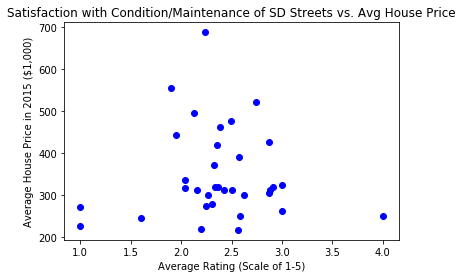

In [58]:
#Plot scatterplot of avg rating vs avg house price
Q8_3_scatter = plt.scatter(rating_and_price['Q8_3'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015 ($1,000)')
plt.title('Satisfaction with Condition/Maintenance of SD Streets vs. Avg House Price')


Text(0.5,1,'Satisfaction with Maintenance of SD Streets/Sidewalks/Infrastructure vs Avg House Price')

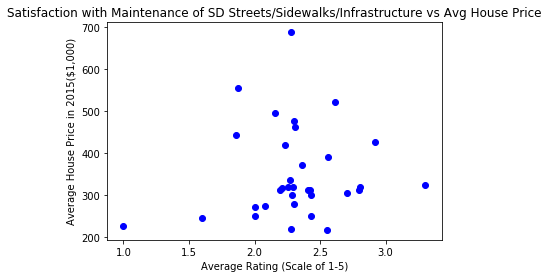

In [59]:
Q3_8_scatter = plt.scatter(rating_and_price['Q3_8'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015($1,000)')
plt.title('Satisfaction with Maintenance of SD Streets/Sidewalks/Infrastructure vs Avg House Price')

Text(0.5,1,'Satisfaction with Condition/maintenance of streets in YOUR neighborhood vs. Average House Price')

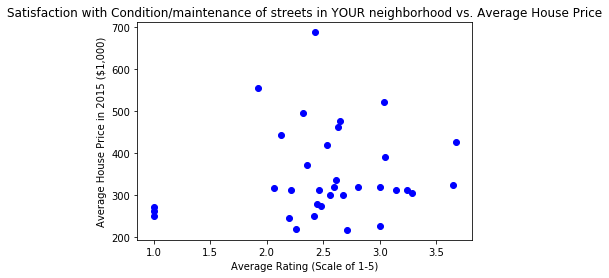

In [60]:
Q8_4_scatter = plt.scatter(rating_and_price['Q8_4'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015 ($1,000)')
plt.title('Satisfaction with Condition/maintenance of streets in YOUR neighborhood vs. Average House Price')

Text(0.5,1,'Satisfaction with Quality of street repairs vs. Avg House Price')

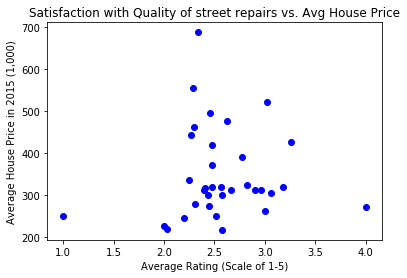

In [62]:
Q8_10_scatter = plt.scatter(rating_and_price['Q8_10'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015 (1,000)')
plt.title('Satisfaction with Quality of street repairs vs. Avg House Price')

In [42]:
#Extract Q14_4 and Q_14_5 (Efforts to address homelessness and Efforts to assist low- to moderate-income residents and communities)
low_income = data[['Q14_4', 'Q14_5', 'ZIP']]

avg_ratings = low_income.groupby('ZIP', as_index=False).mean()
lowest_q144 = avg_ratings.nsmallest(n=5, columns='Q14_4',keep='first')[['ZIP','Q14_4']]
lowest_q145 = avg_ratings.nsmallest(n=5, columns='Q14_5',keep='first')[['ZIP','Q14_5']]
print(lowest_q144, lowest_q145)

      ZIP     Q14_4
0   91910  1.000000
7   92081  1.000000
8   92093  1.000000
45  98764  1.000000
2   91932  1.333333       ZIP  Q14_5
7   92081    1.0
8   92093    1.0
1   91915    2.0
2   91932    2.0
45  98764    2.0


In [43]:
rating_price = avg_ratings.merge(avg_house_prices, left_on='ZIP', right_on='RegionName')
#rating_price.head()
#Compute correlation between avg rating and avg house price for each question
Q14_4_corr = rating_price['Q14_4'].corr(rating_price['2015-01'])
Q14_5_corr = rating_price['Q14_5'].corr(rating_price['2015-01'])

print(Q14_4_corr, Q14_5_corr)

0.0822901357371 0.0195581055351


Text(0.5,1,'Satisfaction with Efforts to Address Homelessness vs. Avg House Price')

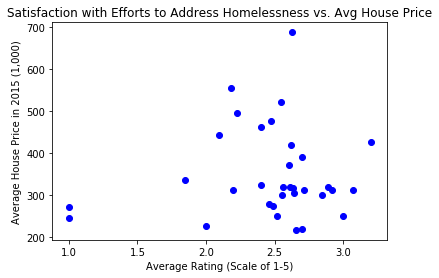

In [64]:
Q14_4_scatter = plt.scatter(rating_price['Q14_4'], rating_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015 (1,000)')
plt.title('Satisfaction with Efforts to Address Homelessness vs. Avg House Price')

Text(0.5,1,'Satisfaction with Efforts to Assist Low to Moderate-Income Residents vs. Avg House Price')

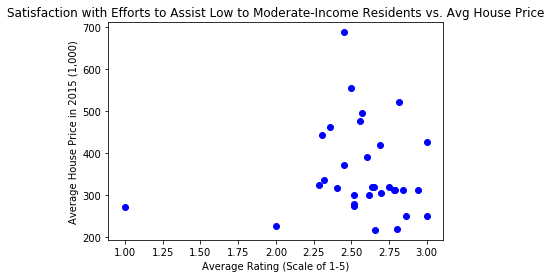

In [65]:
Q14_5_scatter = plt.scatter(rating_price['Q14_5'], rating_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015 (1,000)')
plt.title('Satisfaction with Efforts to Assist Low to Moderate-Income Residents vs. Avg House Price')